In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10, sqrt
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Importing Tweet Data
***

In [3]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [4]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [5]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [6]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [7]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [8]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

'This is some     text that has   char  in it'

In [9]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

'This is some  textthat has char in it'

In [10]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [11]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [12]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

## Word/Token Statistics
***

In [13]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [14]:
word_counts.size

43387

In [15]:
# word_counts.head(20)

In [16]:
# word_counts.tail(20)

In [17]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [18]:
word_counts_reduce.size

43254

In [19]:
# np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

In [20]:
# word_counts_reduce.head(20)

In [21]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [22]:
# word_counts_full_tokenizer.size

In [23]:
# word_counts_full_tokenizer.head(20)

In [24]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [25]:
# tweet_test = tweet_text.loc['2017-09-10 00:03:40'][1]
# print(tweet_test)
# tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
# print(tweet_test.split())
# i=0
# print(f"S: {tweet_test}");i+=1
# #     1: remove URLs:
# tweet_test = re.sub('https?://\S+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     2: remove @mentions, including those with a leading '-' or '.' : 
# tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     3: remove punctuation, but not hashtags:
# tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
# print(f"{i}: {tweet_test}");i+=1
# #     4: remove non-hashtag '#'.
# # tweet_test = re.sub('#\B','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# # tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     6: drop words of < 4 characters, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     7: drop numbers, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

In [26]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That...
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://...
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedi, product, kill, virus, fungal,...
2017-09-10 00:03:40                         [tag, #1, us, biscayn, blvd]
Name: tweet_text, dtype: object


In [27]:
# tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

In [28]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [29]:
word_counts_full_token_clean.size

14439

In [30]:
# word_counts_full_token_clean.head(20)

In [31]:
# word_counts_full_token_clean.tail(20)

In [32]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [33]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [34]:
tweet_len_post[tweet_len_post.index <= 10].sum()

15971

In [35]:
tweet_len_post.sum()

19089

In [36]:
tweet_len

tweet_text
1       37
2      342
3      622
4      753
5      815
6      911
7      956
8     1052
9     1121
10    1022
11    1020
12    1040
13     988
14    1005
15    1308
16    1112
17     876
18     862
19     736
20     587
21     493
22     349
23     317
24     239
25     151
26     163
27      70
28      68
29      33
30      21
31      12
32       6
33       2
Name: tweet_text, dtype: int64

In [37]:
tweet_len_post

0       91
1      874
2     1402
3     1565
4     1745
5     1854
6     1800
7     1812
8     1865
9     1684
10    1279
11    1278
12     870
13     526
14     206
15     117
16      73
17      26
18      14
19       6
20       2
Name: tweet_text, dtype: int64

In [38]:
tweet_len_post[tweet_len_post.index < 11].sum()

15971

In [39]:
tweet_len_post[tweet_len_post.index < 11].sum()/tweet_len_post.sum()

0.8366598564618367

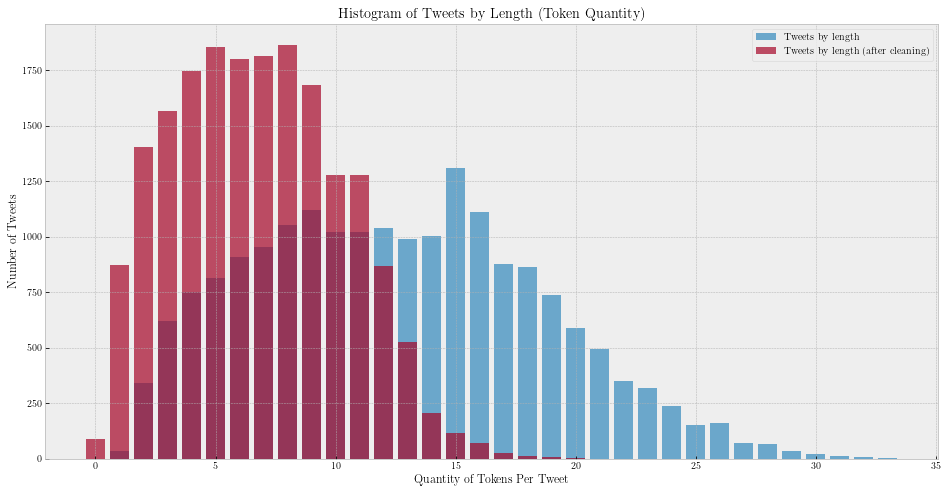

In [40]:
fig_tweet_hist = plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [41]:
search_term = 'irma'

### Window Size: 1-10

In [42]:
# comparison_type = "Min. Word Freq."
# comparison_short = "MinWordFreq"
comparison_type = "Window Size"
comparison_short = "WindowSize"

In [43]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((12)))

In [44]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
    vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, min_count=i)#, window=8, workers=1, size=100, negative=i)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [45]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Comparison Functions

Need a way to write the comparison functions with a larger function that calls them.

how about writing the functions as separate, with a larger function that calls the smaller functions with an argument.

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [46]:
def meanCosSim(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [47]:
def sumCosSimSqrtSum(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [48]:
def dotProductOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [49]:
def cosSimOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if ((len(tweet_as_terms) > 0) & (np.all(score_matrix != np.zeros(vector_dim,)))):
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [50]:
def scalarFunctions(tweet,vector_set,formula='dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet,vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet,vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet,vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet,vector_set)
    else:
        return np.NaN

In [51]:
scalarFunctions(tweets_on_date.iloc[0,1],vectors_series[1],'mcs')

0.2841423600912094

In [52]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [53]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [54]:
func_type = "Dot Product of Tweet Vector and Search Term"
func_short = "DotProduct"
def ScoreTweetFromVectors(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [55]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [56]:
tweet_encoded.iloc[0:5].tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[1],'mcs'))

0    0.284142
1    0.474745
2    0.443170
3    0.470391
4    0.428184
Name: tweet_text, dtype: float64

In [57]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'dp'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [58]:
vectors_series.iloc[1].wv.similar_by_word("irma", topn=10, restrict_vocab=None)

[('directli', 0.6975729465484619),
 ('#hurricaineirma', 0.693352997303009),
 ('project', 0.6834183931350708),
 ('#hurricanirma', 0.6693150997161865),
 ('arriv', 0.6665449142456055),
 ('bike', 0.6664695739746094),
 ('standbi', 0.6634265184402466),
 ('slightli', 0.6634107828140259),
 ('shortli', 0.6598871350288391),
 ('6pm', 0.6598203182220459)]

In [59]:
for i in range(0,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),5))

0.81881
0.81782
0.82425
0.83049
0.82362
0.82875
0.82869
0.82664
0.83092
0.81765
0.8266


In [60]:
fig_0 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or above Threshold")
plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [61]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [62]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

     0         1
0    0  0.000000
1   22  0.720897
2   22  0.727387
3   20  0.728904
4   21  0.723224
5   21  0.726746
6   21  0.726851
7   22  0.724807
8   20  0.730378
9   19  0.719001
10  19  0.726171
22
0.7303783323577928


In [64]:
fig_1 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [65]:
comparison_type = "Hidden Layer Dimensionality"
comparison_short = "HLD"

In [66]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [67]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(1,11):
#     hidden_layer_dim = 50*i
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size 8, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
#     vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=hidden_layer_dim, seed=1, sg=1, negative=5)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

## 2min 29s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [68]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
## 6.67 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [69]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)
## 16.1 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [70]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)

(5906820, 6448200)

In [71]:
opt_vector_model.wv.get_vector('irma')

array([-0.2271969 ,  0.18833187, -0.19160402,  0.7753155 ,  0.8080245 ,
       -0.05930301,  0.69844514, -0.0510646 , -0.7769906 , -0.12354693,
       -0.06585591, -0.26247105,  0.020326  ,  0.8697028 ,  0.08899602,
       -0.86920464,  0.50536513, -0.36330703,  0.9168474 ,  0.35726118,
        0.27475592,  0.10530352,  0.17871495, -0.16618045, -0.16553846,
       -0.48452652, -0.4547413 , -0.58052856,  0.1841515 , -0.01272493,
        0.06664505, -0.34148553,  0.27846003, -0.2542595 ,  0.29775354,
        0.45738304,  0.40860513, -0.01394371,  0.5917295 ,  0.2946316 ,
        0.10121453, -0.62810975, -0.6417219 , -0.01840987,  0.03258538,
       -0.27830097,  0.30654967, -0.61819977, -0.3779787 , -0.12990825,
       -0.8370213 ,  0.04816148, -0.38490513, -0.01222795, -0.5410256 ,
        0.335932  ,  0.70453906,  1.0601602 ,  0.36772513, -0.44534826,
       -0.7478152 , -0.8105647 ,  0.62074673, -0.50262713,  0.21571083,
       -0.72946364, -0.23663476,  0.33650234, -0.04628422,  0.60

In [72]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

def_vector_model = Word2Vec(tweets_tokens, seed=1, sg=1)
    
# train the model over 10 epochs
def_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=200)

(19861370, 25792800)

### AU-ROC Score

In [73]:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'sw_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(def_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [74]:
tweet_encoded.head()

index  irma_rel                                              tweet  \
0      0         1  Wind 2.0 mph N. Barometer 29.880 in, Steady. T...   
1      1         0  There is always beauty regardless the circumst...   
2      2         0  #Carpool #Orlando - gt  #Orlando #KIrkmanRoad ...   
3      3         0  @avictoria_x nah i m chillin my eyes never get...   
4      4         0    @jvnvy @sza That s how I feel bout seein travis   

            timestamp            tweet_id  \
0 2017-09-10 00:00:01  906668545542680576   
1 2017-09-10 00:00:03  906668555185291265   
2 2017-09-10 00:00:03  906668556493889536   
3 2017-09-10 00:00:06  906668570079309830   
4 2017-09-10 00:00:08  906668576056246278   

                                          tweet_text     user_id  \
0  Wind 2.0 mph N. Barometer 29.880 in, Steady. T...  1227982520   
1  There is always beauty regardless the circumst...    42239064   
2  #Carpool #Orlando - gt  #Orlando #KIrkmanRoad ...    87188071   
3  @avictoria_x nah i m chillin my eyes never get...   746764728   
4    @jvnvy @sza That s how I feel bout seein travis  1679199278   

               tweet_coords  \
0    [28.87527778,-81.2525]   
1        [29.5381,-81.2234]   
2  [28.4363045,-81.4797168]   
3                       NaN   
4                       NaN   

                                   tweet_coords_list  tweet_long  ...  \
0  [[[-81.285896, 28.84511], [-81.285896, 28.9640...    -81.2525  ...   
1  [[[-81.279617, 29.424649], [-81.279617, 29.627...    -81.2234  ...   
2  [[[-87.634643, 24.396308], [-87.634643, 31.001...    -81.4797  ...   
3  [[[-81.25235, 28.549308], [-81.25235, 28.58224...    -81.2380  ...   
4  [[[-82.31457, 27.823335], [-82.31457, 27.85374...    -82.2877  ...   

   score_window_10 MM_score_window_10      sw_dp   MM_sw_dp    sw_mcs  \
0        23.617421          48.721082  17.724690  43.004287  0.207530   
1        12.062856          24.884824  11.511818  28.770192  0.236013   
2        10.237707          21.119671   9.374159  23.872677  0.113673   
3        10.583851          21.833742  10.383534  26.185222  0.231620   
4         3.212288           6.626725   2.435779   7.976396  0.079467   

   MM_sw_mcs  sw_scssc  MM_sw_scssc  sw_cstvs  MM_sw_cstvs  
0  24.467073  0.656266    38.183053  0.270669    31.319275  
1  27.181910  0.624431    36.508298  0.402528    43.736359  
2  15.521318  0.341020    21.598631  0.269311    31.191395  
3  26.763166  0.567350    33.505356  0.334761    37.354788  
4  12.260985  0.158933    12.019476  0.211871    25.782326  

[5 rows x 45 columns]

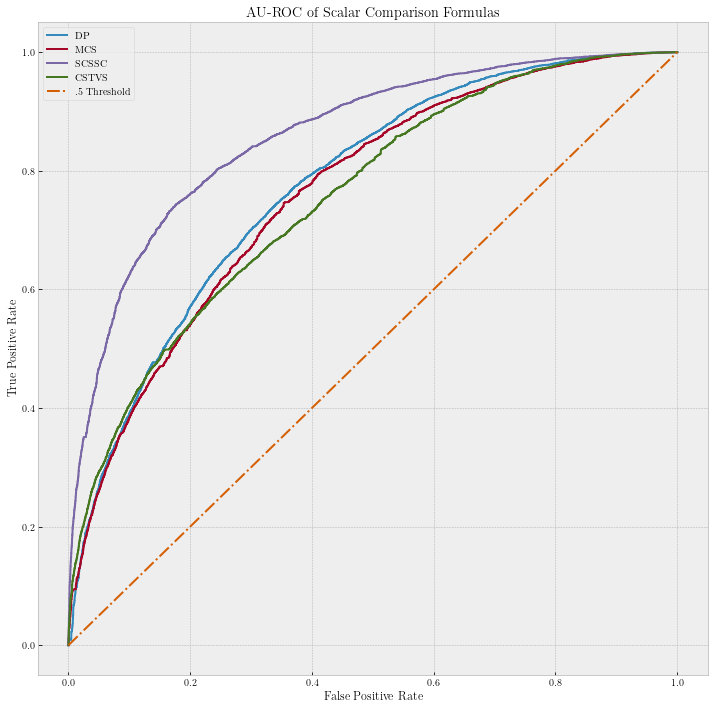

In [75]:
fig_roc_s = plt.figure(figsize=(12,12),facecolor='w')
for i in ['dp','mcs','scssc','cstvs']:
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_sw_{i}'])
    plt.plot(fpr,tpr,label=i.upper())
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AU-ROC of Scalar Comparison Formulas")
plt.legend()
plt.show()
fig_roc_s.savefig(f'./figures/scalar_roc_curve.pdf',bbox_inches='tight')

## Optimized Loops

In [5]:
[10,25,50,100,125,250,500]

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# Hidden Layer Dimensions (hld)
# Minimum Word Count (mwc)
# Word Window Size (wws)
# Negative Sampling (ns)
# Epochs (ep)
# Scoring formulas (sf)

In [7]:
for hld in range(50,501,50):
    for mwc in range(10):
        for wwc in range(1,11):
            for ns in range(10):
                for ep in [10,25,50,100,125,250,500]:
                    vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, workers=1,
                                            size = hld,
                                            min_count = mwc,
                                            window = wws,
                                            negative = ns)
                    vector_model.train(tweets_tokens,
                                       total_examples = len(tweet_text),
                                       epochs=ep)
                    for sf in ['dp','mcs','scssc','cstvs']:
                        print(f'{hld}-{mwc}-{wwc}-{ns}-{ep}-{sf}')
                

50-0-1-0-10-dp
50-0-1-0-10-mcs
50-0-1-0-10-scssc
50-0-1-0-10-cstvs
50-0-1-0-25-dp
50-0-1-0-25-mcs
50-0-1-0-25-scssc
50-0-1-0-25-cstvs
50-0-1-0-50-dp
50-0-1-0-50-mcs
50-0-1-0-50-scssc
50-0-1-0-50-cstvs
50-0-1-0-100-dp
50-0-1-0-100-mcs
50-0-1-0-100-scssc
50-0-1-0-100-cstvs
50-0-1-0-125-dp
50-0-1-0-125-mcs
50-0-1-0-125-scssc
50-0-1-0-125-cstvs
50-0-1-0-250-dp
50-0-1-0-250-mcs
50-0-1-0-250-scssc
50-0-1-0-250-cstvs
50-0-1-0-500-dp
50-0-1-0-500-mcs
50-0-1-0-500-scssc
50-0-1-0-500-cstvs
50-0-1-1-10-dp
50-0-1-1-10-mcs
50-0-1-1-10-scssc
50-0-1-1-10-cstvs
50-0-1-1-25-dp
50-0-1-1-25-mcs
50-0-1-1-25-scssc
50-0-1-1-25-cstvs
50-0-1-1-50-dp
50-0-1-1-50-mcs
50-0-1-1-50-scssc
50-0-1-1-50-cstvs
50-0-1-1-100-dp
50-0-1-1-100-mcs
50-0-1-1-100-scssc
50-0-1-1-100-cstvs
50-0-1-1-125-dp
50-0-1-1-125-mcs
50-0-1-1-125-scssc
50-0-1-1-125-cstvs
50-0-1-1-250-dp
50-0-1-1-250-mcs
50-0-1-1-250-scssc
50-0-1-1-250-cstvs
50-0-1-1-500-dp
50-0-1-1-500-mcs
50-0-1-1-500-scssc
50-0-1-1-500-cstvs
50-0-1-2-10-dp
50-0-1-2-10-mcs

50-1-3-2-250-cstvs
50-1-3-2-500-dp
50-1-3-2-500-mcs
50-1-3-2-500-scssc
50-1-3-2-500-cstvs
50-1-3-3-10-dp
50-1-3-3-10-mcs
50-1-3-3-10-scssc
50-1-3-3-10-cstvs
50-1-3-3-25-dp
50-1-3-3-25-mcs
50-1-3-3-25-scssc
50-1-3-3-25-cstvs
50-1-3-3-50-dp
50-1-3-3-50-mcs
50-1-3-3-50-scssc
50-1-3-3-50-cstvs
50-1-3-3-100-dp
50-1-3-3-100-mcs
50-1-3-3-100-scssc
50-1-3-3-100-cstvs
50-1-3-3-125-dp
50-1-3-3-125-mcs
50-1-3-3-125-scssc
50-1-3-3-125-cstvs
50-1-3-3-250-dp
50-1-3-3-250-mcs
50-1-3-3-250-scssc
50-1-3-3-250-cstvs
50-1-3-3-500-dp
50-1-3-3-500-mcs
50-1-3-3-500-scssc
50-1-3-3-500-cstvs
50-1-3-4-10-dp
50-1-3-4-10-mcs
50-1-3-4-10-scssc
50-1-3-4-10-cstvs
50-1-3-4-25-dp
50-1-3-4-25-mcs
50-1-3-4-25-scssc
50-1-3-4-25-cstvs
50-1-3-4-50-dp
50-1-3-4-50-mcs
50-1-3-4-50-scssc
50-1-3-4-50-cstvs
50-1-3-4-100-dp
50-1-3-4-100-mcs
50-1-3-4-100-scssc
50-1-3-4-100-cstvs
50-1-3-4-125-dp
50-1-3-4-125-mcs
50-1-3-4-125-scssc
50-1-3-4-125-cstvs
50-1-3-4-250-dp
50-1-3-4-250-mcs
50-1-3-4-250-scssc
50-1-3-4-250-cstvs
50-1-3-4-50

50-2-6-1-250-scssc
50-2-6-1-250-cstvs
50-2-6-1-500-dp
50-2-6-1-500-mcs
50-2-6-1-500-scssc
50-2-6-1-500-cstvs
50-2-6-2-10-dp
50-2-6-2-10-mcs
50-2-6-2-10-scssc
50-2-6-2-10-cstvs
50-2-6-2-25-dp
50-2-6-2-25-mcs
50-2-6-2-25-scssc
50-2-6-2-25-cstvs
50-2-6-2-50-dp
50-2-6-2-50-mcs
50-2-6-2-50-scssc
50-2-6-2-50-cstvs
50-2-6-2-100-dp
50-2-6-2-100-mcs
50-2-6-2-100-scssc
50-2-6-2-100-cstvs
50-2-6-2-125-dp
50-2-6-2-125-mcs
50-2-6-2-125-scssc
50-2-6-2-125-cstvs
50-2-6-2-250-dp
50-2-6-2-250-mcs
50-2-6-2-250-scssc
50-2-6-2-250-cstvs
50-2-6-2-500-dp
50-2-6-2-500-mcs
50-2-6-2-500-scssc
50-2-6-2-500-cstvs
50-2-6-3-10-dp
50-2-6-3-10-mcs
50-2-6-3-10-scssc
50-2-6-3-10-cstvs
50-2-6-3-25-dp
50-2-6-3-25-mcs
50-2-6-3-25-scssc
50-2-6-3-25-cstvs
50-2-6-3-50-dp
50-2-6-3-50-mcs
50-2-6-3-50-scssc
50-2-6-3-50-cstvs
50-2-6-3-100-dp
50-2-6-3-100-mcs
50-2-6-3-100-scssc
50-2-6-3-100-cstvs
50-2-6-3-125-dp
50-2-6-3-125-mcs
50-2-6-3-125-scssc
50-2-6-3-125-cstvs
50-2-6-3-250-dp
50-2-6-3-250-mcs
50-2-6-3-250-scssc
50-2-6-3-25

50-3-8-4-10-dp
50-3-8-4-10-mcs
50-3-8-4-10-scssc
50-3-8-4-10-cstvs
50-3-8-4-25-dp
50-3-8-4-25-mcs
50-3-8-4-25-scssc
50-3-8-4-25-cstvs
50-3-8-4-50-dp
50-3-8-4-50-mcs
50-3-8-4-50-scssc
50-3-8-4-50-cstvs
50-3-8-4-100-dp
50-3-8-4-100-mcs
50-3-8-4-100-scssc
50-3-8-4-100-cstvs
50-3-8-4-125-dp
50-3-8-4-125-mcs
50-3-8-4-125-scssc
50-3-8-4-125-cstvs
50-3-8-4-250-dp
50-3-8-4-250-mcs
50-3-8-4-250-scssc
50-3-8-4-250-cstvs
50-3-8-4-500-dp
50-3-8-4-500-mcs
50-3-8-4-500-scssc
50-3-8-4-500-cstvs
50-3-8-5-10-dp
50-3-8-5-10-mcs
50-3-8-5-10-scssc
50-3-8-5-10-cstvs
50-3-8-5-25-dp
50-3-8-5-25-mcs
50-3-8-5-25-scssc
50-3-8-5-25-cstvs
50-3-8-5-50-dp
50-3-8-5-50-mcs
50-3-8-5-50-scssc
50-3-8-5-50-cstvs
50-3-8-5-100-dp
50-3-8-5-100-mcs
50-3-8-5-100-scssc
50-3-8-5-100-cstvs
50-3-8-5-125-dp
50-3-8-5-125-mcs
50-3-8-5-125-scssc
50-3-8-5-125-cstvs
50-3-8-5-250-dp
50-3-8-5-250-mcs
50-3-8-5-250-scssc
50-3-8-5-250-cstvs
50-3-8-5-500-dp
50-3-8-5-500-mcs
50-3-8-5-500-scssc
50-3-8-5-500-cstvs
50-3-8-6-10-dp
50-3-8-6-10-mcs

50-5-2-5-125-dp
50-5-2-5-125-mcs
50-5-2-5-125-scssc
50-5-2-5-125-cstvs
50-5-2-5-250-dp
50-5-2-5-250-mcs
50-5-2-5-250-scssc
50-5-2-5-250-cstvs
50-5-2-5-500-dp
50-5-2-5-500-mcs
50-5-2-5-500-scssc
50-5-2-5-500-cstvs
50-5-2-6-10-dp
50-5-2-6-10-mcs
50-5-2-6-10-scssc
50-5-2-6-10-cstvs
50-5-2-6-25-dp
50-5-2-6-25-mcs
50-5-2-6-25-scssc
50-5-2-6-25-cstvs
50-5-2-6-50-dp
50-5-2-6-50-mcs
50-5-2-6-50-scssc
50-5-2-6-50-cstvs
50-5-2-6-100-dp
50-5-2-6-100-mcs
50-5-2-6-100-scssc
50-5-2-6-100-cstvs
50-5-2-6-125-dp
50-5-2-6-125-mcs
50-5-2-6-125-scssc
50-5-2-6-125-cstvs
50-5-2-6-250-dp
50-5-2-6-250-mcs
50-5-2-6-250-scssc
50-5-2-6-250-cstvs
50-5-2-6-500-dp
50-5-2-6-500-mcs
50-5-2-6-500-scssc
50-5-2-6-500-cstvs
50-5-2-7-10-dp
50-5-2-7-10-mcs
50-5-2-7-10-scssc
50-5-2-7-10-cstvs
50-5-2-7-25-dp
50-5-2-7-25-mcs
50-5-2-7-25-scssc
50-5-2-7-25-cstvs
50-5-2-7-50-dp
50-5-2-7-50-mcs
50-5-2-7-50-scssc
50-5-2-7-50-cstvs
50-5-2-7-100-dp
50-5-2-7-100-mcs
50-5-2-7-100-scssc
50-5-2-7-100-cstvs
50-5-2-7-125-dp
50-5-2-7-125-m

50-6-5-0-100-cstvs
50-6-5-0-125-dp
50-6-5-0-125-mcs
50-6-5-0-125-scssc
50-6-5-0-125-cstvs
50-6-5-0-250-dp
50-6-5-0-250-mcs
50-6-5-0-250-scssc
50-6-5-0-250-cstvs
50-6-5-0-500-dp
50-6-5-0-500-mcs
50-6-5-0-500-scssc
50-6-5-0-500-cstvs
50-6-5-1-10-dp
50-6-5-1-10-mcs
50-6-5-1-10-scssc
50-6-5-1-10-cstvs
50-6-5-1-25-dp
50-6-5-1-25-mcs
50-6-5-1-25-scssc
50-6-5-1-25-cstvs
50-6-5-1-50-dp
50-6-5-1-50-mcs
50-6-5-1-50-scssc
50-6-5-1-50-cstvs
50-6-5-1-100-dp
50-6-5-1-100-mcs
50-6-5-1-100-scssc
50-6-5-1-100-cstvs
50-6-5-1-125-dp
50-6-5-1-125-mcs
50-6-5-1-125-scssc
50-6-5-1-125-cstvs
50-6-5-1-250-dp
50-6-5-1-250-mcs
50-6-5-1-250-scssc
50-6-5-1-250-cstvs
50-6-5-1-500-dp
50-6-5-1-500-mcs
50-6-5-1-500-scssc
50-6-5-1-500-cstvs
50-6-5-2-10-dp
50-6-5-2-10-mcs
50-6-5-2-10-scssc
50-6-5-2-10-cstvs
50-6-5-2-25-dp
50-6-5-2-25-mcs
50-6-5-2-25-scssc
50-6-5-2-25-cstvs
50-6-5-2-50-dp
50-6-5-2-50-mcs
50-6-5-2-50-scssc
50-6-5-2-50-cstvs
50-6-5-2-100-dp
50-6-5-2-100-mcs
50-6-5-2-100-scssc
50-6-5-2-100-cstvs
50-6-5-2-12

50-7-5-6-125-cstvs
50-7-5-6-250-dp
50-7-5-6-250-mcs
50-7-5-6-250-scssc
50-7-5-6-250-cstvs
50-7-5-6-500-dp
50-7-5-6-500-mcs
50-7-5-6-500-scssc
50-7-5-6-500-cstvs
50-7-5-7-10-dp
50-7-5-7-10-mcs
50-7-5-7-10-scssc
50-7-5-7-10-cstvs
50-7-5-7-25-dp
50-7-5-7-25-mcs
50-7-5-7-25-scssc
50-7-5-7-25-cstvs
50-7-5-7-50-dp
50-7-5-7-50-mcs
50-7-5-7-50-scssc
50-7-5-7-50-cstvs
50-7-5-7-100-dp
50-7-5-7-100-mcs
50-7-5-7-100-scssc
50-7-5-7-100-cstvs
50-7-5-7-125-dp
50-7-5-7-125-mcs
50-7-5-7-125-scssc
50-7-5-7-125-cstvs
50-7-5-7-250-dp
50-7-5-7-250-mcs
50-7-5-7-250-scssc
50-7-5-7-250-cstvs
50-7-5-7-500-dp
50-7-5-7-500-mcs
50-7-5-7-500-scssc
50-7-5-7-500-cstvs
50-7-5-8-10-dp
50-7-5-8-10-mcs
50-7-5-8-10-scssc
50-7-5-8-10-cstvs
50-7-5-8-25-dp
50-7-5-8-25-mcs
50-7-5-8-25-scssc
50-7-5-8-25-cstvs
50-7-5-8-50-dp
50-7-5-8-50-mcs
50-7-5-8-50-scssc
50-7-5-8-50-cstvs
50-7-5-8-100-dp
50-7-5-8-100-mcs
50-7-5-8-100-scssc
50-7-5-8-100-cstvs
50-7-5-8-125-dp
50-7-5-8-125-mcs
50-7-5-8-125-scssc
50-7-5-8-125-cstvs
50-7-5-8-25

50-8-8-5-50-mcs
50-8-8-5-50-scssc
50-8-8-5-50-cstvs
50-8-8-5-100-dp
50-8-8-5-100-mcs
50-8-8-5-100-scssc
50-8-8-5-100-cstvs
50-8-8-5-125-dp
50-8-8-5-125-mcs
50-8-8-5-125-scssc
50-8-8-5-125-cstvs
50-8-8-5-250-dp
50-8-8-5-250-mcs
50-8-8-5-250-scssc
50-8-8-5-250-cstvs
50-8-8-5-500-dp
50-8-8-5-500-mcs
50-8-8-5-500-scssc
50-8-8-5-500-cstvs
50-8-8-6-10-dp
50-8-8-6-10-mcs
50-8-8-6-10-scssc
50-8-8-6-10-cstvs
50-8-8-6-25-dp
50-8-8-6-25-mcs
50-8-8-6-25-scssc
50-8-8-6-25-cstvs
50-8-8-6-50-dp
50-8-8-6-50-mcs
50-8-8-6-50-scssc
50-8-8-6-50-cstvs
50-8-8-6-100-dp
50-8-8-6-100-mcs
50-8-8-6-100-scssc
50-8-8-6-100-cstvs
50-8-8-6-125-dp
50-8-8-6-125-mcs
50-8-8-6-125-scssc
50-8-8-6-125-cstvs
50-8-8-6-250-dp
50-8-8-6-250-mcs
50-8-8-6-250-scssc
50-8-8-6-250-cstvs
50-8-8-6-500-dp
50-8-8-6-500-mcs
50-8-8-6-500-scssc
50-8-8-6-500-cstvs
50-8-8-7-10-dp
50-8-8-7-10-mcs
50-8-8-7-10-scssc
50-8-8-7-10-cstvs
50-8-8-7-25-dp
50-8-8-7-25-mcs
50-8-8-7-25-scssc
50-8-8-7-25-cstvs
50-8-8-7-50-dp
50-8-8-7-50-mcs
50-8-8-7-50-sc

50-9-10-7-500-mcs
50-9-10-7-500-scssc
50-9-10-7-500-cstvs
50-9-10-8-10-dp
50-9-10-8-10-mcs
50-9-10-8-10-scssc
50-9-10-8-10-cstvs
50-9-10-8-25-dp
50-9-10-8-25-mcs
50-9-10-8-25-scssc
50-9-10-8-25-cstvs
50-9-10-8-50-dp
50-9-10-8-50-mcs
50-9-10-8-50-scssc
50-9-10-8-50-cstvs
50-9-10-8-100-dp
50-9-10-8-100-mcs
50-9-10-8-100-scssc
50-9-10-8-100-cstvs
50-9-10-8-125-dp
50-9-10-8-125-mcs
50-9-10-8-125-scssc
50-9-10-8-125-cstvs
50-9-10-8-250-dp
50-9-10-8-250-mcs
50-9-10-8-250-scssc
50-9-10-8-250-cstvs
50-9-10-8-500-dp
50-9-10-8-500-mcs
50-9-10-8-500-scssc
50-9-10-8-500-cstvs
50-9-10-9-10-dp
50-9-10-9-10-mcs
50-9-10-9-10-scssc
50-9-10-9-10-cstvs
50-9-10-9-25-dp
50-9-10-9-25-mcs
50-9-10-9-25-scssc
50-9-10-9-25-cstvs
50-9-10-9-50-dp
50-9-10-9-50-mcs
50-9-10-9-50-scssc
50-9-10-9-50-cstvs
50-9-10-9-100-dp
50-9-10-9-100-mcs
50-9-10-9-100-scssc
50-9-10-9-100-cstvs
50-9-10-9-125-dp
50-9-10-9-125-mcs
50-9-10-9-125-scssc
50-9-10-9-125-cstvs
50-9-10-9-250-dp
50-9-10-9-250-mcs
50-9-10-9-250-scssc
50-9-10-9-2

100-1-3-3-50-cstvs
100-1-3-3-100-dp
100-1-3-3-100-mcs
100-1-3-3-100-scssc
100-1-3-3-100-cstvs
100-1-3-3-125-dp
100-1-3-3-125-mcs
100-1-3-3-125-scssc
100-1-3-3-125-cstvs
100-1-3-3-250-dp
100-1-3-3-250-mcs
100-1-3-3-250-scssc
100-1-3-3-250-cstvs
100-1-3-3-500-dp
100-1-3-3-500-mcs
100-1-3-3-500-scssc
100-1-3-3-500-cstvs
100-1-3-4-10-dp
100-1-3-4-10-mcs
100-1-3-4-10-scssc
100-1-3-4-10-cstvs
100-1-3-4-25-dp
100-1-3-4-25-mcs
100-1-3-4-25-scssc
100-1-3-4-25-cstvs
100-1-3-4-50-dp
100-1-3-4-50-mcs
100-1-3-4-50-scssc
100-1-3-4-50-cstvs
100-1-3-4-100-dp
100-1-3-4-100-mcs
100-1-3-4-100-scssc
100-1-3-4-100-cstvs
100-1-3-4-125-dp
100-1-3-4-125-mcs
100-1-3-4-125-scssc
100-1-3-4-125-cstvs
100-1-3-4-250-dp
100-1-3-4-250-mcs
100-1-3-4-250-scssc
100-1-3-4-250-cstvs
100-1-3-4-500-dp
100-1-3-4-500-mcs
100-1-3-4-500-scssc
100-1-3-4-500-cstvs
100-1-3-5-10-dp
100-1-3-5-10-mcs
100-1-3-5-10-scssc
100-1-3-5-10-cstvs
100-1-3-5-25-dp
100-1-3-5-25-mcs
100-1-3-5-25-scssc
100-1-3-5-25-cstvs
100-1-3-5-50-dp
100-1-3-5-

100-2-5-8-100-dp
100-2-5-8-100-mcs
100-2-5-8-100-scssc
100-2-5-8-100-cstvs
100-2-5-8-125-dp
100-2-5-8-125-mcs
100-2-5-8-125-scssc
100-2-5-8-125-cstvs
100-2-5-8-250-dp
100-2-5-8-250-mcs
100-2-5-8-250-scssc
100-2-5-8-250-cstvs
100-2-5-8-500-dp
100-2-5-8-500-mcs
100-2-5-8-500-scssc
100-2-5-8-500-cstvs
100-2-5-9-10-dp
100-2-5-9-10-mcs
100-2-5-9-10-scssc
100-2-5-9-10-cstvs
100-2-5-9-25-dp
100-2-5-9-25-mcs
100-2-5-9-25-scssc
100-2-5-9-25-cstvs
100-2-5-9-50-dp
100-2-5-9-50-mcs
100-2-5-9-50-scssc
100-2-5-9-50-cstvs
100-2-5-9-100-dp
100-2-5-9-100-mcs
100-2-5-9-100-scssc
100-2-5-9-100-cstvs
100-2-5-9-125-dp
100-2-5-9-125-mcs
100-2-5-9-125-scssc
100-2-5-9-125-cstvs
100-2-5-9-250-dp
100-2-5-9-250-mcs
100-2-5-9-250-scssc
100-2-5-9-250-cstvs
100-2-5-9-500-dp
100-2-5-9-500-mcs
100-2-5-9-500-scssc
100-2-5-9-500-cstvs
100-2-6-0-10-dp
100-2-6-0-10-mcs
100-2-6-0-10-scssc
100-2-6-0-10-cstvs
100-2-6-0-25-dp
100-2-6-0-25-mcs
100-2-6-0-25-scssc
100-2-6-0-25-cstvs
100-2-6-0-50-dp
100-2-6-0-50-mcs
100-2-6-0-50

100-3-7-3-50-dp
100-3-7-3-50-mcs
100-3-7-3-50-scssc
100-3-7-3-50-cstvs
100-3-7-3-100-dp
100-3-7-3-100-mcs
100-3-7-3-100-scssc
100-3-7-3-100-cstvs
100-3-7-3-125-dp
100-3-7-3-125-mcs
100-3-7-3-125-scssc
100-3-7-3-125-cstvs
100-3-7-3-250-dp
100-3-7-3-250-mcs
100-3-7-3-250-scssc
100-3-7-3-250-cstvs
100-3-7-3-500-dp
100-3-7-3-500-mcs
100-3-7-3-500-scssc
100-3-7-3-500-cstvs
100-3-7-4-10-dp
100-3-7-4-10-mcs
100-3-7-4-10-scssc
100-3-7-4-10-cstvs
100-3-7-4-25-dp
100-3-7-4-25-mcs
100-3-7-4-25-scssc
100-3-7-4-25-cstvs
100-3-7-4-50-dp
100-3-7-4-50-mcs
100-3-7-4-50-scssc
100-3-7-4-50-cstvs
100-3-7-4-100-dp
100-3-7-4-100-mcs
100-3-7-4-100-scssc
100-3-7-4-100-cstvs
100-3-7-4-125-dp
100-3-7-4-125-mcs
100-3-7-4-125-scssc
100-3-7-4-125-cstvs
100-3-7-4-250-dp
100-3-7-4-250-mcs
100-3-7-4-250-scssc
100-3-7-4-250-cstvs
100-3-7-4-500-dp
100-3-7-4-500-mcs
100-3-7-4-500-scssc
100-3-7-4-500-cstvs
100-3-7-5-10-dp
100-3-7-5-10-mcs
100-3-7-5-10-scssc
100-3-7-5-10-cstvs
100-3-7-5-25-dp
100-3-7-5-25-mcs
100-3-7-5-25

100-4-6-5-100-dp
100-4-6-5-100-mcs
100-4-6-5-100-scssc
100-4-6-5-100-cstvs
100-4-6-5-125-dp
100-4-6-5-125-mcs
100-4-6-5-125-scssc
100-4-6-5-125-cstvs
100-4-6-5-250-dp
100-4-6-5-250-mcs
100-4-6-5-250-scssc
100-4-6-5-250-cstvs
100-4-6-5-500-dp
100-4-6-5-500-mcs
100-4-6-5-500-scssc
100-4-6-5-500-cstvs
100-4-6-6-10-dp
100-4-6-6-10-mcs
100-4-6-6-10-scssc
100-4-6-6-10-cstvs
100-4-6-6-25-dp
100-4-6-6-25-mcs
100-4-6-6-25-scssc
100-4-6-6-25-cstvs
100-4-6-6-50-dp
100-4-6-6-50-mcs
100-4-6-6-50-scssc
100-4-6-6-50-cstvs
100-4-6-6-100-dp
100-4-6-6-100-mcs
100-4-6-6-100-scssc
100-4-6-6-100-cstvs
100-4-6-6-125-dp
100-4-6-6-125-mcs
100-4-6-6-125-scssc
100-4-6-6-125-cstvs
100-4-6-6-250-dp
100-4-6-6-250-mcs
100-4-6-6-250-scssc
100-4-6-6-250-cstvs
100-4-6-6-500-dp
100-4-6-6-500-mcs
100-4-6-6-500-scssc
100-4-6-6-500-cstvs
100-4-6-7-10-dp
100-4-6-7-10-mcs
100-4-6-7-10-scssc
100-4-6-7-10-cstvs
100-4-6-7-25-dp
100-4-6-7-25-mcs
100-4-6-7-25-scssc
100-4-6-7-25-cstvs
100-4-6-7-50-dp
100-4-6-7-50-mcs
100-4-6-7-50

100-5-9-5-500-mcs
100-5-9-5-500-scssc
100-5-9-5-500-cstvs
100-5-9-6-10-dp
100-5-9-6-10-mcs
100-5-9-6-10-scssc
100-5-9-6-10-cstvs
100-5-9-6-25-dp
100-5-9-6-25-mcs
100-5-9-6-25-scssc
100-5-9-6-25-cstvs
100-5-9-6-50-dp
100-5-9-6-50-mcs
100-5-9-6-50-scssc
100-5-9-6-50-cstvs
100-5-9-6-100-dp
100-5-9-6-100-mcs
100-5-9-6-100-scssc
100-5-9-6-100-cstvs
100-5-9-6-125-dp
100-5-9-6-125-mcs
100-5-9-6-125-scssc
100-5-9-6-125-cstvs
100-5-9-6-250-dp
100-5-9-6-250-mcs
100-5-9-6-250-scssc
100-5-9-6-250-cstvs
100-5-9-6-500-dp
100-5-9-6-500-mcs
100-5-9-6-500-scssc
100-5-9-6-500-cstvs
100-5-9-7-10-dp
100-5-9-7-10-mcs
100-5-9-7-10-scssc
100-5-9-7-10-cstvs
100-5-9-7-25-dp
100-5-9-7-25-mcs
100-5-9-7-25-scssc
100-5-9-7-25-cstvs
100-5-9-7-50-dp
100-5-9-7-50-mcs
100-5-9-7-50-scssc
100-5-9-7-50-cstvs
100-5-9-7-100-dp
100-5-9-7-100-mcs
100-5-9-7-100-scssc
100-5-9-7-100-cstvs
100-5-9-7-125-dp
100-5-9-7-125-mcs
100-5-9-7-125-scssc
100-5-9-7-125-cstvs
100-5-9-7-250-dp
100-5-9-7-250-mcs
100-5-9-7-250-scssc
100-5-9-7-2

100-7-1-5-500-cstvs
100-7-1-6-10-dp
100-7-1-6-10-mcs
100-7-1-6-10-scssc
100-7-1-6-10-cstvs
100-7-1-6-25-dp
100-7-1-6-25-mcs
100-7-1-6-25-scssc
100-7-1-6-25-cstvs
100-7-1-6-50-dp
100-7-1-6-50-mcs
100-7-1-6-50-scssc
100-7-1-6-50-cstvs
100-7-1-6-100-dp
100-7-1-6-100-mcs
100-7-1-6-100-scssc
100-7-1-6-100-cstvs
100-7-1-6-125-dp
100-7-1-6-125-mcs
100-7-1-6-125-scssc
100-7-1-6-125-cstvs
100-7-1-6-250-dp
100-7-1-6-250-mcs
100-7-1-6-250-scssc
100-7-1-6-250-cstvs
100-7-1-6-500-dp
100-7-1-6-500-mcs
100-7-1-6-500-scssc
100-7-1-6-500-cstvs
100-7-1-7-10-dp
100-7-1-7-10-mcs
100-7-1-7-10-scssc
100-7-1-7-10-cstvs
100-7-1-7-25-dp
100-7-1-7-25-mcs
100-7-1-7-25-scssc
100-7-1-7-25-cstvs
100-7-1-7-50-dp
100-7-1-7-50-mcs
100-7-1-7-50-scssc
100-7-1-7-50-cstvs
100-7-1-7-100-dp
100-7-1-7-100-mcs
100-7-1-7-100-scssc
100-7-1-7-100-cstvs
100-7-1-7-125-dp
100-7-1-7-125-mcs
100-7-1-7-125-scssc
100-7-1-7-125-cstvs
100-7-1-7-250-dp
100-7-1-7-250-mcs
100-7-1-7-250-scssc
100-7-1-7-250-cstvs
100-7-1-7-500-dp
100-7-1-7-50

100-8-3-9-10-dp
100-8-3-9-10-mcs
100-8-3-9-10-scssc
100-8-3-9-10-cstvs
100-8-3-9-25-dp
100-8-3-9-25-mcs
100-8-3-9-25-scssc
100-8-3-9-25-cstvs
100-8-3-9-50-dp
100-8-3-9-50-mcs
100-8-3-9-50-scssc
100-8-3-9-50-cstvs
100-8-3-9-100-dp
100-8-3-9-100-mcs
100-8-3-9-100-scssc
100-8-3-9-100-cstvs
100-8-3-9-125-dp
100-8-3-9-125-mcs
100-8-3-9-125-scssc
100-8-3-9-125-cstvs
100-8-3-9-250-dp
100-8-3-9-250-mcs
100-8-3-9-250-scssc
100-8-3-9-250-cstvs
100-8-3-9-500-dp
100-8-3-9-500-mcs
100-8-3-9-500-scssc
100-8-3-9-500-cstvs
100-8-4-0-10-dp
100-8-4-0-10-mcs
100-8-4-0-10-scssc
100-8-4-0-10-cstvs
100-8-4-0-25-dp
100-8-4-0-25-mcs
100-8-4-0-25-scssc
100-8-4-0-25-cstvs
100-8-4-0-50-dp
100-8-4-0-50-mcs
100-8-4-0-50-scssc
100-8-4-0-50-cstvs
100-8-4-0-100-dp
100-8-4-0-100-mcs
100-8-4-0-100-scssc
100-8-4-0-100-cstvs
100-8-4-0-125-dp
100-8-4-0-125-mcs
100-8-4-0-125-scssc
100-8-4-0-125-cstvs
100-8-4-0-250-dp
100-8-4-0-250-mcs
100-8-4-0-250-scssc
100-8-4-0-250-cstvs
100-8-4-0-500-dp
100-8-4-0-500-mcs
100-8-4-0-500-

100-9-4-4-250-dp
100-9-4-4-250-mcs
100-9-4-4-250-scssc
100-9-4-4-250-cstvs
100-9-4-4-500-dp
100-9-4-4-500-mcs
100-9-4-4-500-scssc
100-9-4-4-500-cstvs
100-9-4-5-10-dp
100-9-4-5-10-mcs
100-9-4-5-10-scssc
100-9-4-5-10-cstvs
100-9-4-5-25-dp
100-9-4-5-25-mcs
100-9-4-5-25-scssc
100-9-4-5-25-cstvs
100-9-4-5-50-dp
100-9-4-5-50-mcs
100-9-4-5-50-scssc
100-9-4-5-50-cstvs
100-9-4-5-100-dp
100-9-4-5-100-mcs
100-9-4-5-100-scssc
100-9-4-5-100-cstvs
100-9-4-5-125-dp
100-9-4-5-125-mcs
100-9-4-5-125-scssc
100-9-4-5-125-cstvs
100-9-4-5-250-dp
100-9-4-5-250-mcs
100-9-4-5-250-scssc
100-9-4-5-250-cstvs
100-9-4-5-500-dp
100-9-4-5-500-mcs
100-9-4-5-500-scssc
100-9-4-5-500-cstvs
100-9-4-6-10-dp
100-9-4-6-10-mcs
100-9-4-6-10-scssc
100-9-4-6-10-cstvs
100-9-4-6-25-dp
100-9-4-6-25-mcs
100-9-4-6-25-scssc
100-9-4-6-25-cstvs
100-9-4-6-50-dp
100-9-4-6-50-mcs
100-9-4-6-50-scssc
100-9-4-6-50-cstvs
100-9-4-6-100-dp
100-9-4-6-100-mcs
100-9-4-6-100-scssc
100-9-4-6-100-cstvs
100-9-4-6-125-dp
100-9-4-6-125-mcs
100-9-4-6-125-

150-0-7-8-500-mcs
150-0-7-8-500-scssc
150-0-7-8-500-cstvs
150-0-7-9-10-dp
150-0-7-9-10-mcs
150-0-7-9-10-scssc
150-0-7-9-10-cstvs
150-0-7-9-25-dp
150-0-7-9-25-mcs
150-0-7-9-25-scssc
150-0-7-9-25-cstvs
150-0-7-9-50-dp
150-0-7-9-50-mcs
150-0-7-9-50-scssc
150-0-7-9-50-cstvs
150-0-7-9-100-dp
150-0-7-9-100-mcs
150-0-7-9-100-scssc
150-0-7-9-100-cstvs
150-0-7-9-125-dp
150-0-7-9-125-mcs
150-0-7-9-125-scssc
150-0-7-9-125-cstvs
150-0-7-9-250-dp
150-0-7-9-250-mcs
150-0-7-9-250-scssc
150-0-7-9-250-cstvs
150-0-7-9-500-dp
150-0-7-9-500-mcs
150-0-7-9-500-scssc
150-0-7-9-500-cstvs
150-0-8-0-10-dp
150-0-8-0-10-mcs
150-0-8-0-10-scssc
150-0-8-0-10-cstvs
150-0-8-0-25-dp
150-0-8-0-25-mcs
150-0-8-0-25-scssc
150-0-8-0-25-cstvs
150-0-8-0-50-dp
150-0-8-0-50-mcs
150-0-8-0-50-scssc
150-0-8-0-50-cstvs
150-0-8-0-100-dp
150-0-8-0-100-mcs
150-0-8-0-100-scssc
150-0-8-0-100-cstvs
150-0-8-0-125-dp
150-0-8-0-125-mcs
150-0-8-0-125-scssc
150-0-8-0-125-cstvs
150-0-8-0-250-dp
150-0-8-0-250-mcs
150-0-8-0-250-scssc
150-0-8-0-2

150-2-2-1-250-mcs
150-2-2-1-250-scssc
150-2-2-1-250-cstvs
150-2-2-1-500-dp
150-2-2-1-500-mcs
150-2-2-1-500-scssc
150-2-2-1-500-cstvs
150-2-2-2-10-dp
150-2-2-2-10-mcs
150-2-2-2-10-scssc
150-2-2-2-10-cstvs
150-2-2-2-25-dp
150-2-2-2-25-mcs
150-2-2-2-25-scssc
150-2-2-2-25-cstvs
150-2-2-2-50-dp
150-2-2-2-50-mcs
150-2-2-2-50-scssc
150-2-2-2-50-cstvs
150-2-2-2-100-dp
150-2-2-2-100-mcs
150-2-2-2-100-scssc
150-2-2-2-100-cstvs
150-2-2-2-125-dp
150-2-2-2-125-mcs
150-2-2-2-125-scssc
150-2-2-2-125-cstvs
150-2-2-2-250-dp
150-2-2-2-250-mcs
150-2-2-2-250-scssc
150-2-2-2-250-cstvs
150-2-2-2-500-dp
150-2-2-2-500-mcs
150-2-2-2-500-scssc
150-2-2-2-500-cstvs
150-2-2-3-10-dp
150-2-2-3-10-mcs
150-2-2-3-10-scssc
150-2-2-3-10-cstvs
150-2-2-3-25-dp
150-2-2-3-25-mcs
150-2-2-3-25-scssc
150-2-2-3-25-cstvs
150-2-2-3-50-dp
150-2-2-3-50-mcs
150-2-2-3-50-scssc
150-2-2-3-50-cstvs
150-2-2-3-100-dp
150-2-2-3-100-mcs
150-2-2-3-100-scssc
150-2-2-3-100-cstvs
150-2-2-3-125-dp
150-2-2-3-125-mcs
150-2-2-3-125-scssc
150-2-2-3-1

150-3-6-1-125-scssc
150-3-6-1-125-cstvs
150-3-6-1-250-dp
150-3-6-1-250-mcs
150-3-6-1-250-scssc
150-3-6-1-250-cstvs
150-3-6-1-500-dp
150-3-6-1-500-mcs
150-3-6-1-500-scssc
150-3-6-1-500-cstvs
150-3-6-2-10-dp
150-3-6-2-10-mcs
150-3-6-2-10-scssc
150-3-6-2-10-cstvs
150-3-6-2-25-dp
150-3-6-2-25-mcs
150-3-6-2-25-scssc
150-3-6-2-25-cstvs
150-3-6-2-50-dp
150-3-6-2-50-mcs
150-3-6-2-50-scssc
150-3-6-2-50-cstvs
150-3-6-2-100-dp
150-3-6-2-100-mcs
150-3-6-2-100-scssc
150-3-6-2-100-cstvs
150-3-6-2-125-dp
150-3-6-2-125-mcs
150-3-6-2-125-scssc
150-3-6-2-125-cstvs
150-3-6-2-250-dp
150-3-6-2-250-mcs
150-3-6-2-250-scssc
150-3-6-2-250-cstvs
150-3-6-2-500-dp
150-3-6-2-500-mcs
150-3-6-2-500-scssc
150-3-6-2-500-cstvs
150-3-6-3-10-dp
150-3-6-3-10-mcs
150-3-6-3-10-scssc
150-3-6-3-10-cstvs
150-3-6-3-25-dp
150-3-6-3-25-mcs
150-3-6-3-25-scssc
150-3-6-3-25-cstvs
150-3-6-3-50-dp
150-3-6-3-50-mcs
150-3-6-3-50-scssc
150-3-6-3-50-cstvs
150-3-6-3-100-dp
150-3-6-3-100-mcs
150-3-6-3-100-scssc
150-3-6-3-100-cstvs
150-3-6-3

150-4-9-1-500-mcs
150-4-9-1-500-scssc
150-4-9-1-500-cstvs
150-4-9-2-10-dp
150-4-9-2-10-mcs
150-4-9-2-10-scssc
150-4-9-2-10-cstvs
150-4-9-2-25-dp
150-4-9-2-25-mcs
150-4-9-2-25-scssc
150-4-9-2-25-cstvs
150-4-9-2-50-dp
150-4-9-2-50-mcs
150-4-9-2-50-scssc
150-4-9-2-50-cstvs
150-4-9-2-100-dp
150-4-9-2-100-mcs
150-4-9-2-100-scssc
150-4-9-2-100-cstvs
150-4-9-2-125-dp
150-4-9-2-125-mcs
150-4-9-2-125-scssc
150-4-9-2-125-cstvs
150-4-9-2-250-dp
150-4-9-2-250-mcs
150-4-9-2-250-scssc
150-4-9-2-250-cstvs
150-4-9-2-500-dp
150-4-9-2-500-mcs
150-4-9-2-500-scssc
150-4-9-2-500-cstvs
150-4-9-3-10-dp
150-4-9-3-10-mcs
150-4-9-3-10-scssc
150-4-9-3-10-cstvs
150-4-9-3-25-dp
150-4-9-3-25-mcs
150-4-9-3-25-scssc
150-4-9-3-25-cstvs
150-4-9-3-50-dp
150-4-9-3-50-mcs
150-4-9-3-50-scssc
150-4-9-3-50-cstvs
150-4-9-3-100-dp
150-4-9-3-100-mcs
150-4-9-3-100-scssc
150-4-9-3-100-cstvs
150-4-9-3-125-dp
150-4-9-3-125-mcs
150-4-9-3-125-scssc
150-4-9-3-125-cstvs
150-4-9-3-250-dp
150-4-9-3-250-mcs
150-4-9-3-250-scssc
150-4-9-3-2

150-6-4-5-500-cstvs
150-6-4-6-10-dp
150-6-4-6-10-mcs
150-6-4-6-10-scssc
150-6-4-6-10-cstvs
150-6-4-6-25-dp
150-6-4-6-25-mcs
150-6-4-6-25-scssc
150-6-4-6-25-cstvs
150-6-4-6-50-dp
150-6-4-6-50-mcs
150-6-4-6-50-scssc
150-6-4-6-50-cstvs
150-6-4-6-100-dp
150-6-4-6-100-mcs
150-6-4-6-100-scssc
150-6-4-6-100-cstvs
150-6-4-6-125-dp
150-6-4-6-125-mcs
150-6-4-6-125-scssc
150-6-4-6-125-cstvs
150-6-4-6-250-dp
150-6-4-6-250-mcs
150-6-4-6-250-scssc
150-6-4-6-250-cstvs
150-6-4-6-500-dp
150-6-4-6-500-mcs
150-6-4-6-500-scssc
150-6-4-6-500-cstvs
150-6-4-7-10-dp
150-6-4-7-10-mcs
150-6-4-7-10-scssc
150-6-4-7-10-cstvs
150-6-4-7-25-dp
150-6-4-7-25-mcs
150-6-4-7-25-scssc
150-6-4-7-25-cstvs
150-6-4-7-50-dp
150-6-4-7-50-mcs
150-6-4-7-50-scssc
150-6-4-7-50-cstvs
150-6-4-7-100-dp
150-6-4-7-100-mcs
150-6-4-7-100-scssc
150-6-4-7-100-cstvs
150-6-4-7-125-dp
150-6-4-7-125-mcs
150-6-4-7-125-scssc
150-6-4-7-125-cstvs
150-6-4-7-250-dp
150-6-4-7-250-mcs
150-6-4-7-250-scssc
150-6-4-7-250-cstvs
150-6-4-7-500-dp
150-6-4-7-50

150-7-5-8-100-dp
150-7-5-8-100-mcs
150-7-5-8-100-scssc
150-7-5-8-100-cstvs
150-7-5-8-125-dp
150-7-5-8-125-mcs
150-7-5-8-125-scssc
150-7-5-8-125-cstvs
150-7-5-8-250-dp
150-7-5-8-250-mcs
150-7-5-8-250-scssc
150-7-5-8-250-cstvs
150-7-5-8-500-dp
150-7-5-8-500-mcs
150-7-5-8-500-scssc
150-7-5-8-500-cstvs
150-7-5-9-10-dp
150-7-5-9-10-mcs
150-7-5-9-10-scssc
150-7-5-9-10-cstvs
150-7-5-9-25-dp
150-7-5-9-25-mcs
150-7-5-9-25-scssc
150-7-5-9-25-cstvs
150-7-5-9-50-dp
150-7-5-9-50-mcs
150-7-5-9-50-scssc
150-7-5-9-50-cstvs
150-7-5-9-100-dp
150-7-5-9-100-mcs
150-7-5-9-100-scssc
150-7-5-9-100-cstvs
150-7-5-9-125-dp
150-7-5-9-125-mcs
150-7-5-9-125-scssc
150-7-5-9-125-cstvs
150-7-5-9-250-dp
150-7-5-9-250-mcs
150-7-5-9-250-scssc
150-7-5-9-250-cstvs
150-7-5-9-500-dp
150-7-5-9-500-mcs
150-7-5-9-500-scssc
150-7-5-9-500-cstvs
150-7-6-0-10-dp
150-7-6-0-10-mcs
150-7-6-0-10-scssc
150-7-6-0-10-cstvs
150-7-6-0-25-dp
150-7-6-0-25-mcs
150-7-6-0-25-scssc
150-7-6-0-25-cstvs
150-7-6-0-50-dp
150-7-6-0-50-mcs
150-7-6-0-50

150-8-10-4-25-dp
150-8-10-4-25-mcs
150-8-10-4-25-scssc
150-8-10-4-25-cstvs
150-8-10-4-50-dp
150-8-10-4-50-mcs
150-8-10-4-50-scssc
150-8-10-4-50-cstvs
150-8-10-4-100-dp
150-8-10-4-100-mcs
150-8-10-4-100-scssc
150-8-10-4-100-cstvs
150-8-10-4-125-dp
150-8-10-4-125-mcs
150-8-10-4-125-scssc
150-8-10-4-125-cstvs
150-8-10-4-250-dp
150-8-10-4-250-mcs
150-8-10-4-250-scssc
150-8-10-4-250-cstvs
150-8-10-4-500-dp
150-8-10-4-500-mcs
150-8-10-4-500-scssc
150-8-10-4-500-cstvs
150-8-10-5-10-dp
150-8-10-5-10-mcs
150-8-10-5-10-scssc
150-8-10-5-10-cstvs
150-8-10-5-25-dp
150-8-10-5-25-mcs
150-8-10-5-25-scssc
150-8-10-5-25-cstvs
150-8-10-5-50-dp
150-8-10-5-50-mcs
150-8-10-5-50-scssc
150-8-10-5-50-cstvs
150-8-10-5-100-dp
150-8-10-5-100-mcs
150-8-10-5-100-scssc
150-8-10-5-100-cstvs
150-8-10-5-125-dp
150-8-10-5-125-mcs
150-8-10-5-125-scssc
150-8-10-5-125-cstvs
150-8-10-5-250-dp
150-8-10-5-250-mcs
150-8-10-5-250-scssc
150-8-10-5-250-cstvs
150-8-10-5-500-dp
150-8-10-5-500-mcs
150-8-10-5-500-scssc
150-8-10-5-500

200-0-2-6-100-scssc
200-0-2-6-100-cstvs
200-0-2-6-125-dp
200-0-2-6-125-mcs
200-0-2-6-125-scssc
200-0-2-6-125-cstvs
200-0-2-6-250-dp
200-0-2-6-250-mcs
200-0-2-6-250-scssc
200-0-2-6-250-cstvs
200-0-2-6-500-dp
200-0-2-6-500-mcs
200-0-2-6-500-scssc
200-0-2-6-500-cstvs
200-0-2-7-10-dp
200-0-2-7-10-mcs
200-0-2-7-10-scssc
200-0-2-7-10-cstvs
200-0-2-7-25-dp
200-0-2-7-25-mcs
200-0-2-7-25-scssc
200-0-2-7-25-cstvs
200-0-2-7-50-dp
200-0-2-7-50-mcs
200-0-2-7-50-scssc
200-0-2-7-50-cstvs
200-0-2-7-100-dp
200-0-2-7-100-mcs
200-0-2-7-100-scssc
200-0-2-7-100-cstvs
200-0-2-7-125-dp
200-0-2-7-125-mcs
200-0-2-7-125-scssc
200-0-2-7-125-cstvs
200-0-2-7-250-dp
200-0-2-7-250-mcs
200-0-2-7-250-scssc
200-0-2-7-250-cstvs
200-0-2-7-500-dp
200-0-2-7-500-mcs
200-0-2-7-500-scssc
200-0-2-7-500-cstvs
200-0-2-8-10-dp
200-0-2-8-10-mcs
200-0-2-8-10-scssc
200-0-2-8-10-cstvs
200-0-2-8-25-dp
200-0-2-8-25-mcs
200-0-2-8-25-scssc
200-0-2-8-25-cstvs
200-0-2-8-50-dp
200-0-2-8-50-mcs
200-0-2-8-50-scssc
200-0-2-8-50-cstvs
200-0-2-8

200-1-3-8-250-mcs
200-1-3-8-250-scssc
200-1-3-8-250-cstvs
200-1-3-8-500-dp
200-1-3-8-500-mcs
200-1-3-8-500-scssc
200-1-3-8-500-cstvs
200-1-3-9-10-dp
200-1-3-9-10-mcs
200-1-3-9-10-scssc
200-1-3-9-10-cstvs
200-1-3-9-25-dp
200-1-3-9-25-mcs
200-1-3-9-25-scssc
200-1-3-9-25-cstvs
200-1-3-9-50-dp
200-1-3-9-50-mcs
200-1-3-9-50-scssc
200-1-3-9-50-cstvs
200-1-3-9-100-dp
200-1-3-9-100-mcs
200-1-3-9-100-scssc
200-1-3-9-100-cstvs
200-1-3-9-125-dp
200-1-3-9-125-mcs
200-1-3-9-125-scssc
200-1-3-9-125-cstvs
200-1-3-9-250-dp
200-1-3-9-250-mcs
200-1-3-9-250-scssc
200-1-3-9-250-cstvs
200-1-3-9-500-dp
200-1-3-9-500-mcs
200-1-3-9-500-scssc
200-1-3-9-500-cstvs
200-1-4-0-10-dp
200-1-4-0-10-mcs
200-1-4-0-10-scssc
200-1-4-0-10-cstvs
200-1-4-0-25-dp
200-1-4-0-25-mcs
200-1-4-0-25-scssc
200-1-4-0-25-cstvs
200-1-4-0-50-dp
200-1-4-0-50-mcs
200-1-4-0-50-scssc
200-1-4-0-50-cstvs
200-1-4-0-100-dp
200-1-4-0-100-mcs
200-1-4-0-100-scssc
200-1-4-0-100-cstvs
200-1-4-0-125-dp
200-1-4-0-125-mcs
200-1-4-0-125-scssc
200-1-4-0-1

200-2-4-9-10-dp
200-2-4-9-10-mcs
200-2-4-9-10-scssc
200-2-4-9-10-cstvs
200-2-4-9-25-dp
200-2-4-9-25-mcs
200-2-4-9-25-scssc
200-2-4-9-25-cstvs
200-2-4-9-50-dp
200-2-4-9-50-mcs
200-2-4-9-50-scssc
200-2-4-9-50-cstvs
200-2-4-9-100-dp
200-2-4-9-100-mcs
200-2-4-9-100-scssc
200-2-4-9-100-cstvs
200-2-4-9-125-dp
200-2-4-9-125-mcs
200-2-4-9-125-scssc
200-2-4-9-125-cstvs
200-2-4-9-250-dp
200-2-4-9-250-mcs
200-2-4-9-250-scssc
200-2-4-9-250-cstvs
200-2-4-9-500-dp
200-2-4-9-500-mcs
200-2-4-9-500-scssc
200-2-4-9-500-cstvs
200-2-5-0-10-dp
200-2-5-0-10-mcs
200-2-5-0-10-scssc
200-2-5-0-10-cstvs
200-2-5-0-25-dp
200-2-5-0-25-mcs
200-2-5-0-25-scssc
200-2-5-0-25-cstvs
200-2-5-0-50-dp
200-2-5-0-50-mcs
200-2-5-0-50-scssc
200-2-5-0-50-cstvs
200-2-5-0-100-dp
200-2-5-0-100-mcs
200-2-5-0-100-scssc
200-2-5-0-100-cstvs
200-2-5-0-125-dp
200-2-5-0-125-mcs
200-2-5-0-125-scssc
200-2-5-0-125-cstvs
200-2-5-0-250-dp
200-2-5-0-250-mcs
200-2-5-0-250-scssc
200-2-5-0-250-cstvs
200-2-5-0-500-dp
200-2-5-0-500-mcs
200-2-5-0-500-

200-3-8-2-100-scssc
200-3-8-2-100-cstvs
200-3-8-2-125-dp
200-3-8-2-125-mcs
200-3-8-2-125-scssc
200-3-8-2-125-cstvs
200-3-8-2-250-dp
200-3-8-2-250-mcs
200-3-8-2-250-scssc
200-3-8-2-250-cstvs
200-3-8-2-500-dp
200-3-8-2-500-mcs
200-3-8-2-500-scssc
200-3-8-2-500-cstvs
200-3-8-3-10-dp
200-3-8-3-10-mcs
200-3-8-3-10-scssc
200-3-8-3-10-cstvs
200-3-8-3-25-dp
200-3-8-3-25-mcs
200-3-8-3-25-scssc
200-3-8-3-25-cstvs
200-3-8-3-50-dp
200-3-8-3-50-mcs
200-3-8-3-50-scssc
200-3-8-3-50-cstvs
200-3-8-3-100-dp
200-3-8-3-100-mcs
200-3-8-3-100-scssc
200-3-8-3-100-cstvs
200-3-8-3-125-dp
200-3-8-3-125-mcs
200-3-8-3-125-scssc
200-3-8-3-125-cstvs
200-3-8-3-250-dp
200-3-8-3-250-mcs
200-3-8-3-250-scssc
200-3-8-3-250-cstvs
200-3-8-3-500-dp
200-3-8-3-500-mcs
200-3-8-3-500-scssc
200-3-8-3-500-cstvs
200-3-8-4-10-dp
200-3-8-4-10-mcs
200-3-8-4-10-scssc
200-3-8-4-10-cstvs
200-3-8-4-25-dp
200-3-8-4-25-mcs
200-3-8-4-25-scssc
200-3-8-4-25-cstvs
200-3-8-4-50-dp
200-3-8-4-50-mcs
200-3-8-4-50-scssc
200-3-8-4-50-cstvs
200-3-8-4

200-5-1-1-10-mcs
200-5-1-1-10-scssc
200-5-1-1-10-cstvs
200-5-1-1-25-dp
200-5-1-1-25-mcs
200-5-1-1-25-scssc
200-5-1-1-25-cstvs
200-5-1-1-50-dp
200-5-1-1-50-mcs
200-5-1-1-50-scssc
200-5-1-1-50-cstvs
200-5-1-1-100-dp
200-5-1-1-100-mcs
200-5-1-1-100-scssc
200-5-1-1-100-cstvs
200-5-1-1-125-dp
200-5-1-1-125-mcs
200-5-1-1-125-scssc
200-5-1-1-125-cstvs
200-5-1-1-250-dp
200-5-1-1-250-mcs
200-5-1-1-250-scssc
200-5-1-1-250-cstvs
200-5-1-1-500-dp
200-5-1-1-500-mcs
200-5-1-1-500-scssc
200-5-1-1-500-cstvs
200-5-1-2-10-dp
200-5-1-2-10-mcs
200-5-1-2-10-scssc
200-5-1-2-10-cstvs
200-5-1-2-25-dp
200-5-1-2-25-mcs
200-5-1-2-25-scssc
200-5-1-2-25-cstvs
200-5-1-2-50-dp
200-5-1-2-50-mcs
200-5-1-2-50-scssc
200-5-1-2-50-cstvs
200-5-1-2-100-dp
200-5-1-2-100-mcs
200-5-1-2-100-scssc
200-5-1-2-100-cstvs
200-5-1-2-125-dp
200-5-1-2-125-mcs
200-5-1-2-125-scssc
200-5-1-2-125-cstvs
200-5-1-2-250-dp
200-5-1-2-250-mcs
200-5-1-2-250-scssc
200-5-1-2-250-cstvs
200-5-1-2-500-dp
200-5-1-2-500-mcs
200-5-1-2-500-scssc
200-5-1-2-

200-6-6-7-25-cstvs
200-6-6-7-50-dp
200-6-6-7-50-mcs
200-6-6-7-50-scssc
200-6-6-7-50-cstvs
200-6-6-7-100-dp
200-6-6-7-100-mcs
200-6-6-7-100-scssc
200-6-6-7-100-cstvs
200-6-6-7-125-dp
200-6-6-7-125-mcs
200-6-6-7-125-scssc
200-6-6-7-125-cstvs
200-6-6-7-250-dp
200-6-6-7-250-mcs
200-6-6-7-250-scssc
200-6-6-7-250-cstvs
200-6-6-7-500-dp
200-6-6-7-500-mcs
200-6-6-7-500-scssc
200-6-6-7-500-cstvs
200-6-6-8-10-dp
200-6-6-8-10-mcs
200-6-6-8-10-scssc
200-6-6-8-10-cstvs
200-6-6-8-25-dp
200-6-6-8-25-mcs
200-6-6-8-25-scssc
200-6-6-8-25-cstvs
200-6-6-8-50-dp
200-6-6-8-50-mcs
200-6-6-8-50-scssc
200-6-6-8-50-cstvs
200-6-6-8-100-dp
200-6-6-8-100-mcs
200-6-6-8-100-scssc
200-6-6-8-100-cstvs
200-6-6-8-125-dp
200-6-6-8-125-mcs
200-6-6-8-125-scssc
200-6-6-8-125-cstvs
200-6-6-8-250-dp
200-6-6-8-250-mcs
200-6-6-8-250-scssc
200-6-6-8-250-cstvs
200-6-6-8-500-dp
200-6-6-8-500-mcs
200-6-6-8-500-scssc
200-6-6-8-500-cstvs
200-6-6-9-10-dp
200-6-6-9-10-mcs
200-6-6-9-10-scssc
200-6-6-9-10-cstvs
200-6-6-9-25-dp
200-6-6-9-

200-7-9-2-500-cstvs
200-7-9-3-10-dp
200-7-9-3-10-mcs
200-7-9-3-10-scssc
200-7-9-3-10-cstvs
200-7-9-3-25-dp
200-7-9-3-25-mcs
200-7-9-3-25-scssc
200-7-9-3-25-cstvs
200-7-9-3-50-dp
200-7-9-3-50-mcs
200-7-9-3-50-scssc
200-7-9-3-50-cstvs
200-7-9-3-100-dp
200-7-9-3-100-mcs
200-7-9-3-100-scssc
200-7-9-3-100-cstvs
200-7-9-3-125-dp
200-7-9-3-125-mcs
200-7-9-3-125-scssc
200-7-9-3-125-cstvs
200-7-9-3-250-dp
200-7-9-3-250-mcs
200-7-9-3-250-scssc
200-7-9-3-250-cstvs
200-7-9-3-500-dp
200-7-9-3-500-mcs
200-7-9-3-500-scssc
200-7-9-3-500-cstvs
200-7-9-4-10-dp
200-7-9-4-10-mcs
200-7-9-4-10-scssc
200-7-9-4-10-cstvs
200-7-9-4-25-dp
200-7-9-4-25-mcs
200-7-9-4-25-scssc
200-7-9-4-25-cstvs
200-7-9-4-50-dp
200-7-9-4-50-mcs
200-7-9-4-50-scssc
200-7-9-4-50-cstvs
200-7-9-4-100-dp
200-7-9-4-100-mcs
200-7-9-4-100-scssc
200-7-9-4-100-cstvs
200-7-9-4-125-dp
200-7-9-4-125-mcs
200-7-9-4-125-scssc
200-7-9-4-125-cstvs
200-7-9-4-250-dp
200-7-9-4-250-mcs
200-7-9-4-250-scssc
200-7-9-4-250-cstvs
200-7-9-4-500-dp
200-7-9-4-50

200-9-2-1-500-mcs
200-9-2-1-500-scssc
200-9-2-1-500-cstvs
200-9-2-2-10-dp
200-9-2-2-10-mcs
200-9-2-2-10-scssc
200-9-2-2-10-cstvs
200-9-2-2-25-dp
200-9-2-2-25-mcs
200-9-2-2-25-scssc
200-9-2-2-25-cstvs
200-9-2-2-50-dp
200-9-2-2-50-mcs
200-9-2-2-50-scssc
200-9-2-2-50-cstvs
200-9-2-2-100-dp
200-9-2-2-100-mcs
200-9-2-2-100-scssc
200-9-2-2-100-cstvs
200-9-2-2-125-dp
200-9-2-2-125-mcs
200-9-2-2-125-scssc
200-9-2-2-125-cstvs
200-9-2-2-250-dp
200-9-2-2-250-mcs
200-9-2-2-250-scssc
200-9-2-2-250-cstvs
200-9-2-2-500-dp
200-9-2-2-500-mcs
200-9-2-2-500-scssc
200-9-2-2-500-cstvs
200-9-2-3-10-dp
200-9-2-3-10-mcs
200-9-2-3-10-scssc
200-9-2-3-10-cstvs
200-9-2-3-25-dp
200-9-2-3-25-mcs
200-9-2-3-25-scssc
200-9-2-3-25-cstvs
200-9-2-3-50-dp
200-9-2-3-50-mcs
200-9-2-3-50-scssc
200-9-2-3-50-cstvs
200-9-2-3-100-dp
200-9-2-3-100-mcs
200-9-2-3-100-scssc
200-9-2-3-100-cstvs
200-9-2-3-125-dp
200-9-2-3-125-mcs
200-9-2-3-125-scssc
200-9-2-3-125-cstvs
200-9-2-3-250-dp
200-9-2-3-250-mcs
200-9-2-3-250-scssc
200-9-2-3-2

250-0-4-5-250-scssc
250-0-4-5-250-cstvs
250-0-4-5-500-dp
250-0-4-5-500-mcs
250-0-4-5-500-scssc
250-0-4-5-500-cstvs
250-0-4-6-10-dp
250-0-4-6-10-mcs
250-0-4-6-10-scssc
250-0-4-6-10-cstvs
250-0-4-6-25-dp
250-0-4-6-25-mcs
250-0-4-6-25-scssc
250-0-4-6-25-cstvs
250-0-4-6-50-dp
250-0-4-6-50-mcs
250-0-4-6-50-scssc
250-0-4-6-50-cstvs
250-0-4-6-100-dp
250-0-4-6-100-mcs
250-0-4-6-100-scssc
250-0-4-6-100-cstvs
250-0-4-6-125-dp
250-0-4-6-125-mcs
250-0-4-6-125-scssc
250-0-4-6-125-cstvs
250-0-4-6-250-dp
250-0-4-6-250-mcs
250-0-4-6-250-scssc
250-0-4-6-250-cstvs
250-0-4-6-500-dp
250-0-4-6-500-mcs
250-0-4-6-500-scssc
250-0-4-6-500-cstvs
250-0-4-7-10-dp
250-0-4-7-10-mcs
250-0-4-7-10-scssc
250-0-4-7-10-cstvs
250-0-4-7-25-dp
250-0-4-7-25-mcs
250-0-4-7-25-scssc
250-0-4-7-25-cstvs
250-0-4-7-50-dp
250-0-4-7-50-mcs
250-0-4-7-50-scssc
250-0-4-7-50-cstvs
250-0-4-7-100-dp
250-0-4-7-100-mcs
250-0-4-7-100-scssc
250-0-4-7-100-cstvs
250-0-4-7-125-dp
250-0-4-7-125-mcs
250-0-4-7-125-scssc
250-0-4-7-125-cstvs
250-0-4-7

250-1-8-5-250-mcs
250-1-8-5-250-scssc
250-1-8-5-250-cstvs
250-1-8-5-500-dp
250-1-8-5-500-mcs
250-1-8-5-500-scssc
250-1-8-5-500-cstvs
250-1-8-6-10-dp
250-1-8-6-10-mcs
250-1-8-6-10-scssc
250-1-8-6-10-cstvs
250-1-8-6-25-dp
250-1-8-6-25-mcs
250-1-8-6-25-scssc
250-1-8-6-25-cstvs
250-1-8-6-50-dp
250-1-8-6-50-mcs
250-1-8-6-50-scssc
250-1-8-6-50-cstvs
250-1-8-6-100-dp
250-1-8-6-100-mcs
250-1-8-6-100-scssc
250-1-8-6-100-cstvs
250-1-8-6-125-dp
250-1-8-6-125-mcs
250-1-8-6-125-scssc
250-1-8-6-125-cstvs
250-1-8-6-250-dp
250-1-8-6-250-mcs
250-1-8-6-250-scssc
250-1-8-6-250-cstvs
250-1-8-6-500-dp
250-1-8-6-500-mcs
250-1-8-6-500-scssc
250-1-8-6-500-cstvs
250-1-8-7-10-dp
250-1-8-7-10-mcs
250-1-8-7-10-scssc
250-1-8-7-10-cstvs
250-1-8-7-25-dp
250-1-8-7-25-mcs
250-1-8-7-25-scssc
250-1-8-7-25-cstvs
250-1-8-7-50-dp
250-1-8-7-50-mcs
250-1-8-7-50-scssc
250-1-8-7-50-cstvs
250-1-8-7-100-dp
250-1-8-7-100-mcs
250-1-8-7-100-scssc
250-1-8-7-100-cstvs
250-1-8-7-125-dp
250-1-8-7-125-mcs
250-1-8-7-125-scssc
250-1-8-7-1

250-3-2-6-250-cstvs
250-3-2-6-500-dp
250-3-2-6-500-mcs
250-3-2-6-500-scssc
250-3-2-6-500-cstvs
250-3-2-7-10-dp
250-3-2-7-10-mcs
250-3-2-7-10-scssc
250-3-2-7-10-cstvs
250-3-2-7-25-dp
250-3-2-7-25-mcs
250-3-2-7-25-scssc
250-3-2-7-25-cstvs
250-3-2-7-50-dp
250-3-2-7-50-mcs
250-3-2-7-50-scssc
250-3-2-7-50-cstvs
250-3-2-7-100-dp
250-3-2-7-100-mcs
250-3-2-7-100-scssc
250-3-2-7-100-cstvs
250-3-2-7-125-dp
250-3-2-7-125-mcs
250-3-2-7-125-scssc
250-3-2-7-125-cstvs
250-3-2-7-250-dp
250-3-2-7-250-mcs
250-3-2-7-250-scssc
250-3-2-7-250-cstvs
250-3-2-7-500-dp
250-3-2-7-500-mcs
250-3-2-7-500-scssc
250-3-2-7-500-cstvs
250-3-2-8-10-dp
250-3-2-8-10-mcs
250-3-2-8-10-scssc
250-3-2-8-10-cstvs
250-3-2-8-25-dp
250-3-2-8-25-mcs
250-3-2-8-25-scssc
250-3-2-8-25-cstvs
250-3-2-8-50-dp
250-3-2-8-50-mcs
250-3-2-8-50-scssc
250-3-2-8-50-cstvs
250-3-2-8-100-dp
250-3-2-8-100-mcs
250-3-2-8-100-scssc
250-3-2-8-100-cstvs
250-3-2-8-125-dp
250-3-2-8-125-mcs
250-3-2-8-125-scssc
250-3-2-8-125-cstvs
250-3-2-8-250-dp
250-3-2-8-25

250-4-5-2-100-scssc
250-4-5-2-100-cstvs
250-4-5-2-125-dp
250-4-5-2-125-mcs
250-4-5-2-125-scssc
250-4-5-2-125-cstvs
250-4-5-2-250-dp
250-4-5-2-250-mcs
250-4-5-2-250-scssc
250-4-5-2-250-cstvs
250-4-5-2-500-dp
250-4-5-2-500-mcs
250-4-5-2-500-scssc
250-4-5-2-500-cstvs
250-4-5-3-10-dp
250-4-5-3-10-mcs
250-4-5-3-10-scssc
250-4-5-3-10-cstvs
250-4-5-3-25-dp
250-4-5-3-25-mcs
250-4-5-3-25-scssc
250-4-5-3-25-cstvs
250-4-5-3-50-dp
250-4-5-3-50-mcs
250-4-5-3-50-scssc
250-4-5-3-50-cstvs
250-4-5-3-100-dp
250-4-5-3-100-mcs
250-4-5-3-100-scssc
250-4-5-3-100-cstvs
250-4-5-3-125-dp
250-4-5-3-125-mcs
250-4-5-3-125-scssc
250-4-5-3-125-cstvs
250-4-5-3-250-dp
250-4-5-3-250-mcs
250-4-5-3-250-scssc
250-4-5-3-250-cstvs
250-4-5-3-500-dp
250-4-5-3-500-mcs
250-4-5-3-500-scssc
250-4-5-3-500-cstvs
250-4-5-4-10-dp
250-4-5-4-10-mcs
250-4-5-4-10-scssc
250-4-5-4-10-cstvs
250-4-5-4-25-dp
250-4-5-4-25-mcs
250-4-5-4-25-scssc
250-4-5-4-25-cstvs
250-4-5-4-50-dp
250-4-5-4-50-mcs
250-4-5-4-50-scssc
250-4-5-4-50-cstvs
250-4-5-4

250-5-7-2-10-scssc
250-5-7-2-10-cstvs
250-5-7-2-25-dp
250-5-7-2-25-mcs
250-5-7-2-25-scssc
250-5-7-2-25-cstvs
250-5-7-2-50-dp
250-5-7-2-50-mcs
250-5-7-2-50-scssc
250-5-7-2-50-cstvs
250-5-7-2-100-dp
250-5-7-2-100-mcs
250-5-7-2-100-scssc
250-5-7-2-100-cstvs
250-5-7-2-125-dp
250-5-7-2-125-mcs
250-5-7-2-125-scssc
250-5-7-2-125-cstvs
250-5-7-2-250-dp
250-5-7-2-250-mcs
250-5-7-2-250-scssc
250-5-7-2-250-cstvs
250-5-7-2-500-dp
250-5-7-2-500-mcs
250-5-7-2-500-scssc
250-5-7-2-500-cstvs
250-5-7-3-10-dp
250-5-7-3-10-mcs
250-5-7-3-10-scssc
250-5-7-3-10-cstvs
250-5-7-3-25-dp
250-5-7-3-25-mcs
250-5-7-3-25-scssc
250-5-7-3-25-cstvs
250-5-7-3-50-dp
250-5-7-3-50-mcs
250-5-7-3-50-scssc
250-5-7-3-50-cstvs
250-5-7-3-100-dp
250-5-7-3-100-mcs
250-5-7-3-100-scssc
250-5-7-3-100-cstvs
250-5-7-3-125-dp
250-5-7-3-125-mcs
250-5-7-3-125-scssc
250-5-7-3-125-cstvs
250-5-7-3-250-dp
250-5-7-3-250-mcs
250-5-7-3-250-scssc
250-5-7-3-250-cstvs
250-5-7-3-500-dp
250-5-7-3-500-mcs
250-5-7-3-500-scssc
250-5-7-3-500-cstvs
250-5-7

250-7-1-4-10-scssc
250-7-1-4-10-cstvs
250-7-1-4-25-dp
250-7-1-4-25-mcs
250-7-1-4-25-scssc
250-7-1-4-25-cstvs
250-7-1-4-50-dp
250-7-1-4-50-mcs
250-7-1-4-50-scssc
250-7-1-4-50-cstvs
250-7-1-4-100-dp
250-7-1-4-100-mcs
250-7-1-4-100-scssc
250-7-1-4-100-cstvs
250-7-1-4-125-dp
250-7-1-4-125-mcs
250-7-1-4-125-scssc
250-7-1-4-125-cstvs
250-7-1-4-250-dp
250-7-1-4-250-mcs
250-7-1-4-250-scssc
250-7-1-4-250-cstvs
250-7-1-4-500-dp
250-7-1-4-500-mcs
250-7-1-4-500-scssc
250-7-1-4-500-cstvs
250-7-1-5-10-dp
250-7-1-5-10-mcs
250-7-1-5-10-scssc
250-7-1-5-10-cstvs
250-7-1-5-25-dp
250-7-1-5-25-mcs
250-7-1-5-25-scssc
250-7-1-5-25-cstvs
250-7-1-5-50-dp
250-7-1-5-50-mcs
250-7-1-5-50-scssc
250-7-1-5-50-cstvs
250-7-1-5-100-dp
250-7-1-5-100-mcs
250-7-1-5-100-scssc
250-7-1-5-100-cstvs
250-7-1-5-125-dp
250-7-1-5-125-mcs
250-7-1-5-125-scssc
250-7-1-5-125-cstvs
250-7-1-5-250-dp
250-7-1-5-250-mcs
250-7-1-5-250-scssc
250-7-1-5-250-cstvs
250-7-1-5-500-dp
250-7-1-5-500-mcs
250-7-1-5-500-scssc
250-7-1-5-500-cstvs
250-7-1

250-8-5-0-50-mcs
250-8-5-0-50-scssc
250-8-5-0-50-cstvs
250-8-5-0-100-dp
250-8-5-0-100-mcs
250-8-5-0-100-scssc
250-8-5-0-100-cstvs
250-8-5-0-125-dp
250-8-5-0-125-mcs
250-8-5-0-125-scssc
250-8-5-0-125-cstvs
250-8-5-0-250-dp
250-8-5-0-250-mcs
250-8-5-0-250-scssc
250-8-5-0-250-cstvs
250-8-5-0-500-dp
250-8-5-0-500-mcs
250-8-5-0-500-scssc
250-8-5-0-500-cstvs
250-8-5-1-10-dp
250-8-5-1-10-mcs
250-8-5-1-10-scssc
250-8-5-1-10-cstvs
250-8-5-1-25-dp
250-8-5-1-25-mcs
250-8-5-1-25-scssc
250-8-5-1-25-cstvs
250-8-5-1-50-dp
250-8-5-1-50-mcs
250-8-5-1-50-scssc
250-8-5-1-50-cstvs
250-8-5-1-100-dp
250-8-5-1-100-mcs
250-8-5-1-100-scssc
250-8-5-1-100-cstvs
250-8-5-1-125-dp
250-8-5-1-125-mcs
250-8-5-1-125-scssc
250-8-5-1-125-cstvs
250-8-5-1-250-dp
250-8-5-1-250-mcs
250-8-5-1-250-scssc
250-8-5-1-250-cstvs
250-8-5-1-500-dp
250-8-5-1-500-mcs
250-8-5-1-500-scssc
250-8-5-1-500-cstvs
250-8-5-2-10-dp
250-8-5-2-10-mcs
250-8-5-2-10-scssc
250-8-5-2-10-cstvs
250-8-5-2-25-dp
250-8-5-2-25-mcs
250-8-5-2-25-scssc
250-8-5-2

KeyboardInterrupt: 

In [76]:
for i in ['dp','mcs','scssc','cstvs']:
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_sw_{i}']),4))

0.7747
0.7627
0.8595
0.7543


### Related Words by 1 Hour Increments

In [75]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("1HR")
end_date = pd.to_datetime("2017-09-11 00:00:00")
top_num_words = 20
search_term = 'irma'

In [76]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    opt_vector_model_1hr = Word2Vec(tweets_tokens, min_count=3, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    opt_vector_model_1hr.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    opt_word_matrix_1hr = opt_vector_model_1hr.wv[opt_vector_model_1hr.wv.vocab]
    terms_from_range = pd.DataFrame.from_records(opt_vector_model_1hr.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

In [73]:
related_words

2017-09-10 00:00:00   Cos_Sim 2017-09-10 01:00:00   Cos_Sim  \
0              #repost  0.265424             alreadi  0.606717   
1             #orlando  0.240334                 hit  0.590511   
2                staff  0.224587                pray  0.578684   
3                   al  0.212681                 get  0.562127   
4                 cool  0.212410                talk  0.560051   
5              alreadi  0.211902              friend  0.553401   
6                 time  0.200519                stay  0.548691   
7                 soon  0.199584                like  0.544238   
8                 need  0.196033               night  0.543114   
9               beauti  0.194624                safe  0.543033   
10                look  0.187923                shit  0.538583   
11               speed  0.187596                wait  0.525599   
12             airport  0.186879             everyon  0.518285   
13                mile  0.184611               bitch  0.517613   
14                back  0.183439                last  0.506139   
15              expect  0.180501                home  0.501063   
16               readi  0.174340            tomorrow  0.498914   
17             protect  0.169028                come  0.495525   
18                long  0.167226                back  0.494883   
19               ahead  0.166217                sinc  0.490252   

   2017-09-10 02:00:00   Cos_Sim 2017-09-10 03:00:00   Cos_Sim  \
0                storm  0.909438                soon  0.252239   
1                 stay  0.904531             #repost  0.244770   
2                 like  0.901244                look  0.232497   
3                updat  0.900670                 let  0.224351   
4                 back  0.899459                hard  0.218504   
5               realli  0.899030                hear  0.215968   
6                thank  0.898961               front  0.209566   
7                 good  0.897408              outsid  0.207140   
8             tomorrow  0.896601              import  0.203823   
9                 fuck  0.895543               nigga  0.199595   
10      #hurricaneirma  0.893185                pray  0.197796   
11                 get  0.891285                time  0.197133   
12                  us  0.888558              realli  0.173714   
13                wait  0.887852                said  0.172112   
14                  go  0.886544               readi  0.172065   
15               readi  0.886319               point  0.167147   
16                safe  0.884978             florida  0.166901   
17                pray  0.882919                ryan  0.163728   
18                 see  0.882319                fuck  0.162409   
19               watch  0.881526                want  0.161856   

   2017-09-10 04:00:00   Cos_Sim  ... 2017-09-10 20:00:00   Cos_Sim  \
0              surpris  0.188537  ...                 get  0.947654   
1                photo  0.181449  ...                come  0.944228   
2                 soon  0.179610  ...                  go  0.932334   
3                 intl  0.176604  ...               right  0.925093   
4                 hard  0.166168  ...               thank  0.924381   
5              deltona  0.164060  ...                good  0.923284   
6                 look  0.158768  ...               still  0.920706   
7                 #tbt  0.157732  ...                hous  0.920248   
8              airport  0.157586  ...                feel  0.916373   
9                 pray  0.155617  ...                noth  0.916281   
10                cool  0.154737  ...      #hurricaneirma  0.914525   
11                girl  0.152002  ...                  us  0.914469   
12                want  0.150922  ...                back  0.912894   
13              realli  0.144286  ...               thing  0.912624   
14               nigga  0.138094  ...                 one  0.907880   
15                said  0.130166  ...               #irma  0.907687   
16                 one

In [78]:
related_words.to_csv('./top_words_no_scores.csv')

### Network Graphs

In [76]:
token_counts = tweets_tokens.apply(pd.Series).stack().value_counts()

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for pair in word_pairs:
#     edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

In [77]:
num_words = 10
tweet_graph = nx.Graph()
for word_count in token_counts.iteritems():
    tweet_graph.add_node(word_count[0],count=word_count[1])
for word in list(opt_vector_model.wv.vocab.keys()):
    word_scores = opt_vector_model.wv.most_similar(word, topn=num_words)
    for i in range(num_words):
        tweet_graph.add_edge(word,word_scores[i][0],weight=word_scores[i][1])
nx.write_gexf(tweet_graph,path=f'./tweet_graph_{num_words}.gexf')

In [207]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'scssc'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [208]:
for i in range(1,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

0.779
0.784
0.784
0.781
0.779
0.779
0.777
0.777
0.776
0.775


In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

In [ ]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    window_label = f"{comparison_type}: {25*i + 25}"
    plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_hld_2.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [49]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

0.813429069570445

In [50]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

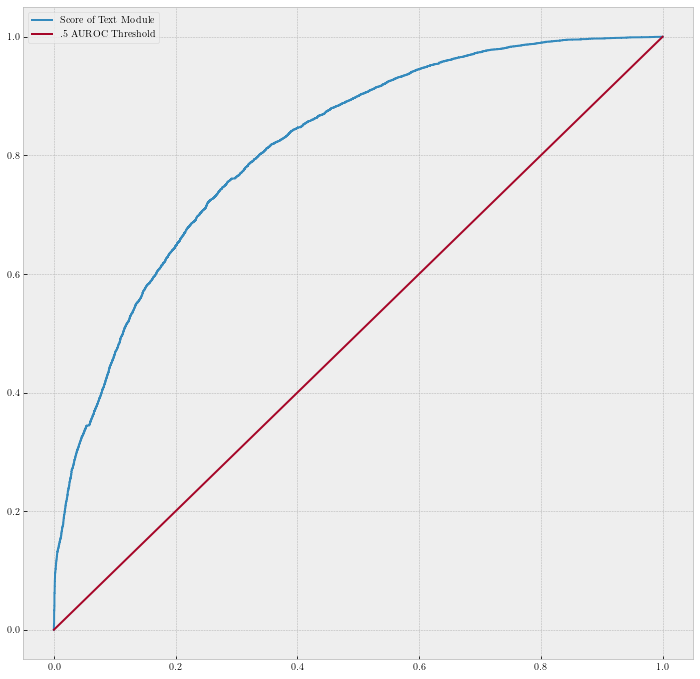

In [51]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

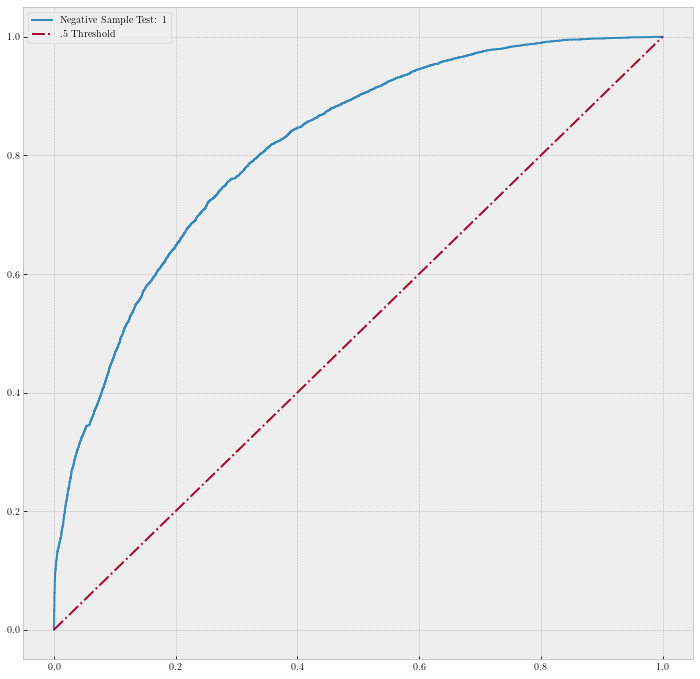

In [52]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')